<center><h1><b><mark style="background-color: #ff1493; color: black;">IP CW Draft</mark></b></h1></center>


In this coursework, you will be asked to develop an image processing pipeline to separate flower material from background. This requires a processing pipeline that usually includes at least some of the following steps:

- <b>Colour space conversion</b>: choose a colour space. Any can be used, but most people choose to work in a lower-dimensional (<3) space whenever possible.

- <b>Noise reduction</b>: depending on image quality, some form of noise suppression may be required.

- <b>Thresholding/Segmentation</b>: image regions corresponding to nuclei must be identified, and thresholding is a common approach. The method used varies and may be global or local. Methods that automatically determine the threshold value  have obvious advantages over those that require user interaction. Binary image processing: Identifying a perfect threshold value or segmentation  method is almost impossible, and most methods will result in some mis-classified  pixels. A further binary image processing stage is often needed to clean up the image, hopefully leaving it containing only regions that correspond to plants.  Nothing, however, is perfect.

- <b>Dataset</b>: Images of three species of flowers are collected in a folder available from  Moodle. The images are selected based on the complexity of their foreground/background features and categorised into three sub-folders (e.g., easy, medium, and hard) within the input-image folder. To aid with analysing the effectiveness of your solution, ground truth for each image is provided within the  ground-truth folder, again categorised within three sub-folders (e.g., easy, medium, and hard).

https://www.researchgate.net/publication/286225842_Flower_recognition_system_based_on_image_processing


- make bg dark as possible - background flowers also should become darker
- center of flower should become lighter, including shadows on inner of flower

Functions List:
- convert to black and white
- convert image using binary thresholding
- negation
- contrast stretching
- gain
- bias
- guassian filtering
- 

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def convert_BW(img):
    
    # converts the image to grayscale
    
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_bw
    
def binary_threshold(img, threshold_num, max_num):
    
    # threshold_num -> the number which decides whether the pixel should be black or white
    # max_num -> highest gray value, eg. 255
    
    _, bi_image = cv2.threshold(img, threshold_num, max_num, cv2.THRESH_BINARY)
    return bi_image

def contrast_stretch(img, min_num, max_num): 
    
    # adjusts the image to the new minimum and maximum values
    # min_num -> lowest gray value, eg. 0
    # max_num -> highest gray value, eg. 255
    
    contrast_img = cv2.normalize(img, None, min_num, max_num, norm_type=cv2.NORM_MINMAX)
    return contrast_img

def negation(img):
    # Ensure the image is in uint8 format
    if img.dtype != 'uint8':
        img = img.astype('uint8')
    negated_image = 255 - img
    return negated_image

def median_blur(img,kernel_size):
    
    # kernel_size -> size of kernel, like 3x3? 5x5?
    
    blurred_image = cv2.medianBlur(img, kernel_size)
    return blurred_image

def inc_gain(img,gain_factor):
    # gain_factor -> by how much increase for gain?
    scaled_image = img * gain_factor
    scaled_image[scaled_image > 255] = 255
    return scaled_image
    
def inc_bias(img, bias_value):
    biased_image = img + bias_value
    biased_image[biased_image > 255] = 255
    return biased_image

def histogramEq(img):
    if len(img.shape) > 2:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    
    if gray_img.dtype != 'uint8':
        gray_img = gray_img.astype('uint8')
    
    equalise = cv2.equalizeHist(gray_img)
    
    return equalise

def otsu_Thresholding(img):
    _, otsu_threshold = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_threshold

def edge_Detect(img):
    edges = cv2.Canny(img, threshold1=50, threshold2=100)
    return edges

def gamma_Correction(img, g):
    gamma = g
    gamma_img = ((img / 255) ** gamma) * 255
    gamma_img = gamma_img.astype("uint8")
    return gamma_img

def morphology_close(image,kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closing_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closing_image

def morphology_open(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opening_image

def calculate_miou(ground_truth, final):
    print(ground_truth.shape)
    print(final.shape)
    similarity = ssim(ground_truth, final)
    return similarity

def roi_remove_white(image):
    _, mask = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)
    mask = cv2.bitwise_not(mask)
    roi_img = cv2.bitwise_and(image, image, mask=mask)
    return roi_img
  
  # roi for flowers using canny edge detection and choosing largest contour assuming that is the flower
def create_flower_mask(image):
    gray_image = image

    bilateral_filtered = cv2.bilateralFilter(gray_image, 9, 75, 75)
    edges = cv2.Canny(bilateral_filtered, 50, 150)
    dilated_edges = cv2.dilate(edges, np.ones((5, 5), np.uint8), iterations=2)

    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    inverted_mask = cv2.bitwise_not(mask)

    roi = cv2.bitwise_and(image, image, mask=mask)
    roi[mask == 0] = 255

    return roi,largest_contour

def erosion(binary_image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    
    return eroded_image

def dilation(binary_image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)
    
    return dilated_image

def draw_contour(img,contour):
    white_bg = np.ones_like(img) * 255    
    contour_img = cv2.drawContours(white_bg.copy(), [contour], -1, (0, 0, 0), thickness=2)
    return contour_img

def draw_border(binary_image):
    bordered_image = binary_image.copy()
    height, width = binary_image.shape[:2]
    cv2.rectangle(bordered_image, (0, 0), (width-1, height-1), 255, thickness=1)
    return bordered_image
  
def extract_foreground(image): 
    if image.dtype != 'uint8':
        image = image.astype('uint8')
    height, width = image.shape[:2]
    mask = np.zeros(image.shape[:2], np.uint8)
    rectangle = (10, 10, width, height)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.convertScaleAbs(image)
    cv2.grabCut(image, mask, rectangle, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    foreground_mask = np.where((mask == 1) | (mask == 3), 255, 0).astype('uint8')
    foreground = cv2.bitwise_and(image, image, mask=foreground_mask)
    return foreground


def extractRedGroundT(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    mask = cv2.inRange(hsv, lower_red, upper_red)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    largest_contour_mask = np.zeros_like(mask)
    cv2.drawContours(largest_contour_mask, contours[:1], -1, (255), thickness=cv2.FILLED)
    red_areas = cv2.bitwise_and(image, image, mask=largest_contour_mask)
    
    return red_areas

def sharpen_img(image, strength=1.5, sigma=1.0):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

def watershed_segmentation(img1):
    # Convert the image to 3-channel color (if it's not already)
    img = img1
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding to obtain a binary image
    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Apply morphological operations to enhance the segmentation
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Distance transformation
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Apply watershed algorithm
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Highlight the boundaries
    
    return img

# def save_images(images,difficulty,number):
#     #save images to pipeline here


# customizable function to apply all processing functions to image
def image_pipeline(img,ground):
    
#     ground_t = extractRedGroundT(ground)
#      ground_t = convert_BW(ground_t)
#     ground_t = negation(ground_t)

    _, ground_t = cv2.threshold(convert_BW(ground), 50, 255, cv2.THRESH_BINARY)
    
    bw_img = convert_BW(img)

    sharp_img = sharpen_img(bw_img)
    
    g_img0= gamma_Correction(sharp_img,1.5)
    
    blur_img=median_blur(g_img0,21)
    
    g_img= gamma_Correction(blur_img,3.5)
    
#     gain_img = inc_gain(g_img,0.25)
    
    foreground_img = extract_foreground(g_img)
    
    negated_img = negation(foreground_img)
    
#     w_segment_img = watershed_segmentation(negated_img)
    
    hist_eq_img = histogramEq(negated_img)
    
    g_img2 = gamma_Correction(hist_eq_img,1.5)

    _, bi_thresh_img = cv2.threshold(g_img2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    morph_close_img = morphology_close(bi_thresh_img,11)
    morph_open_img = morphology_open(morph_close_img,7)
    
    border_img = draw_border(morph_open_img)
    
#     erosion_img = erosion(morph_open_img, 3)
    
#     dilated_img = dilation(morph_open_img, 15)
    
    roi, contour = create_flower_mask(border_img)
    
#     contour_img = draw_contour(img,contour)
    
    final_img = negation(roi)
    ground_t = negation(ground_t)
    

    print("similarity: ",calculate_miou(final_img,ground_t))

    # display half-processed images
    images = [bw_img, sharp_img, g_img0, blur_img, g_img, foreground_img, negated_img, g_img2, bi_thresh_img, morph_close_img, morph_open_img, border_img, roi, final_img, ground_t]
    titles = ["bw","sharp", "gamma0", "blur", "gamma", "fground", "negate", "gamma2", "binary threshold", "morph close", "morph open", "border", "roi", "final", "ground_t"]
    fig, axes = plt.subplots(4, 4, figsize=(17, 17))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

#     return images


In [3]:
def display_pipeline(image_pipeline):
    
    # image_pipeline -> name of your image_pipeline function, which will be applied to all images in dataset and displayed
    
    file_names = ["easy","medium","hard"]
    
    # getting all images file directories
    # C:\\Users\\Manoharan\\Desktop\\IP CW\\Dataset\\input_images\\easy\\easy_1.jpg
    
#     input_file_directory = "C:\\Users\\ansha\\OneDrive - University of Nottingham Malaysia\\Uni\\ImageProcessing\\Dataset\\Dataset\\input_images\\"
#     ground_truth_directory =  "C:\\Users\\ansha\\OneDrive - University of Nottingham Malaysia\\Uni\\ImageProcessing\\Dataset\\Dataset\\ground_truths\\"
    input_file_directory = '.\\Dataset\\Dataset\\input_images\\'
    ground_truth_directory =  '.\\Dataset\\Dataset\\ground_truths\\'
    
    for j in file_names:
        
        first_file_directory = input_file_directory+j+"\\"+j+"_"+"1"+".jpg"
        sec_file_directory = input_file_directory+j+"\\"+j+"_"+"2"+".jpg"
        third_file_directory = input_file_directory+j+"\\"+j+"_"+"3"+".jpg"
        
        ground1=ground_truth_directory+j+"\\"+j+"_"+"1"+".png"
        ground2=ground_truth_directory+j+"\\"+j+"_"+"2"+".png"
        ground3=ground_truth_directory+j+"\\"+j+"_"+"3"+".png"

        # getting input images
        image1=cv2.imread(first_file_directory, cv2.IMREAD_COLOR)
        image2=cv2.imread(sec_file_directory, cv2.IMREAD_COLOR)
        image3=cv2.imread(third_file_directory, cv2.IMREAD_COLOR)

        
        # getting all processed images
        gimage1=cv2.imread(ground1, cv2.IMREAD_COLOR)
        gimage2=cv2.imread(ground2, cv2.IMREAD_COLOR)
        gimage3=cv2.imread(ground3, cv2.IMREAD_COLOR)
        
        # getting final images
        fimage1=image_pipeline(image1,gimage1)
        fimage2=image_pipeline(image2,gimage2)
        fimage3=image_pipeline(image3,gimage3)
        
#         contour_img1, border_img1, roi1, final_img1 = image_pipeline(image1,gimage1)
#         contour_img2, border_img2, roi2, final_img2 = image_pipeline(image2,gimage2)
#         contour_img3, border_img3, roi3, final_img3 = image_pipeline(image3,gimage3)
        
#         cv2.imwrite("contour_img1.jpg", contour_img1)
#         cv2.imwrite("border_img1.jpg", border_img1)
#         cv2.imwrite("roi1.jpg", roi1)
#         cv2.imwrite("final_img1.jpg", final_img1)

#         cv2.imwrite("contour_img2.jpg", contour_img2)
#         cv2.imwrite("border_img2.jpg", border_img2)
#         cv2.imwrite("roi2.jpg", roi2)
#         cv2.imwrite("final_img2.jpg", final_img2)

#         cv2.imwrite("contour_img3.jpg", contour_img3)
#         cv2.imwrite("border_img3.jpg", border_img3)
#         cv2.imwrite("roi3.jpg", roi3)
#         cv2.imwrite("final_img3.jpg", final_img3)

(500, 666)
(500, 666)
similarity:  0.8638425879287095


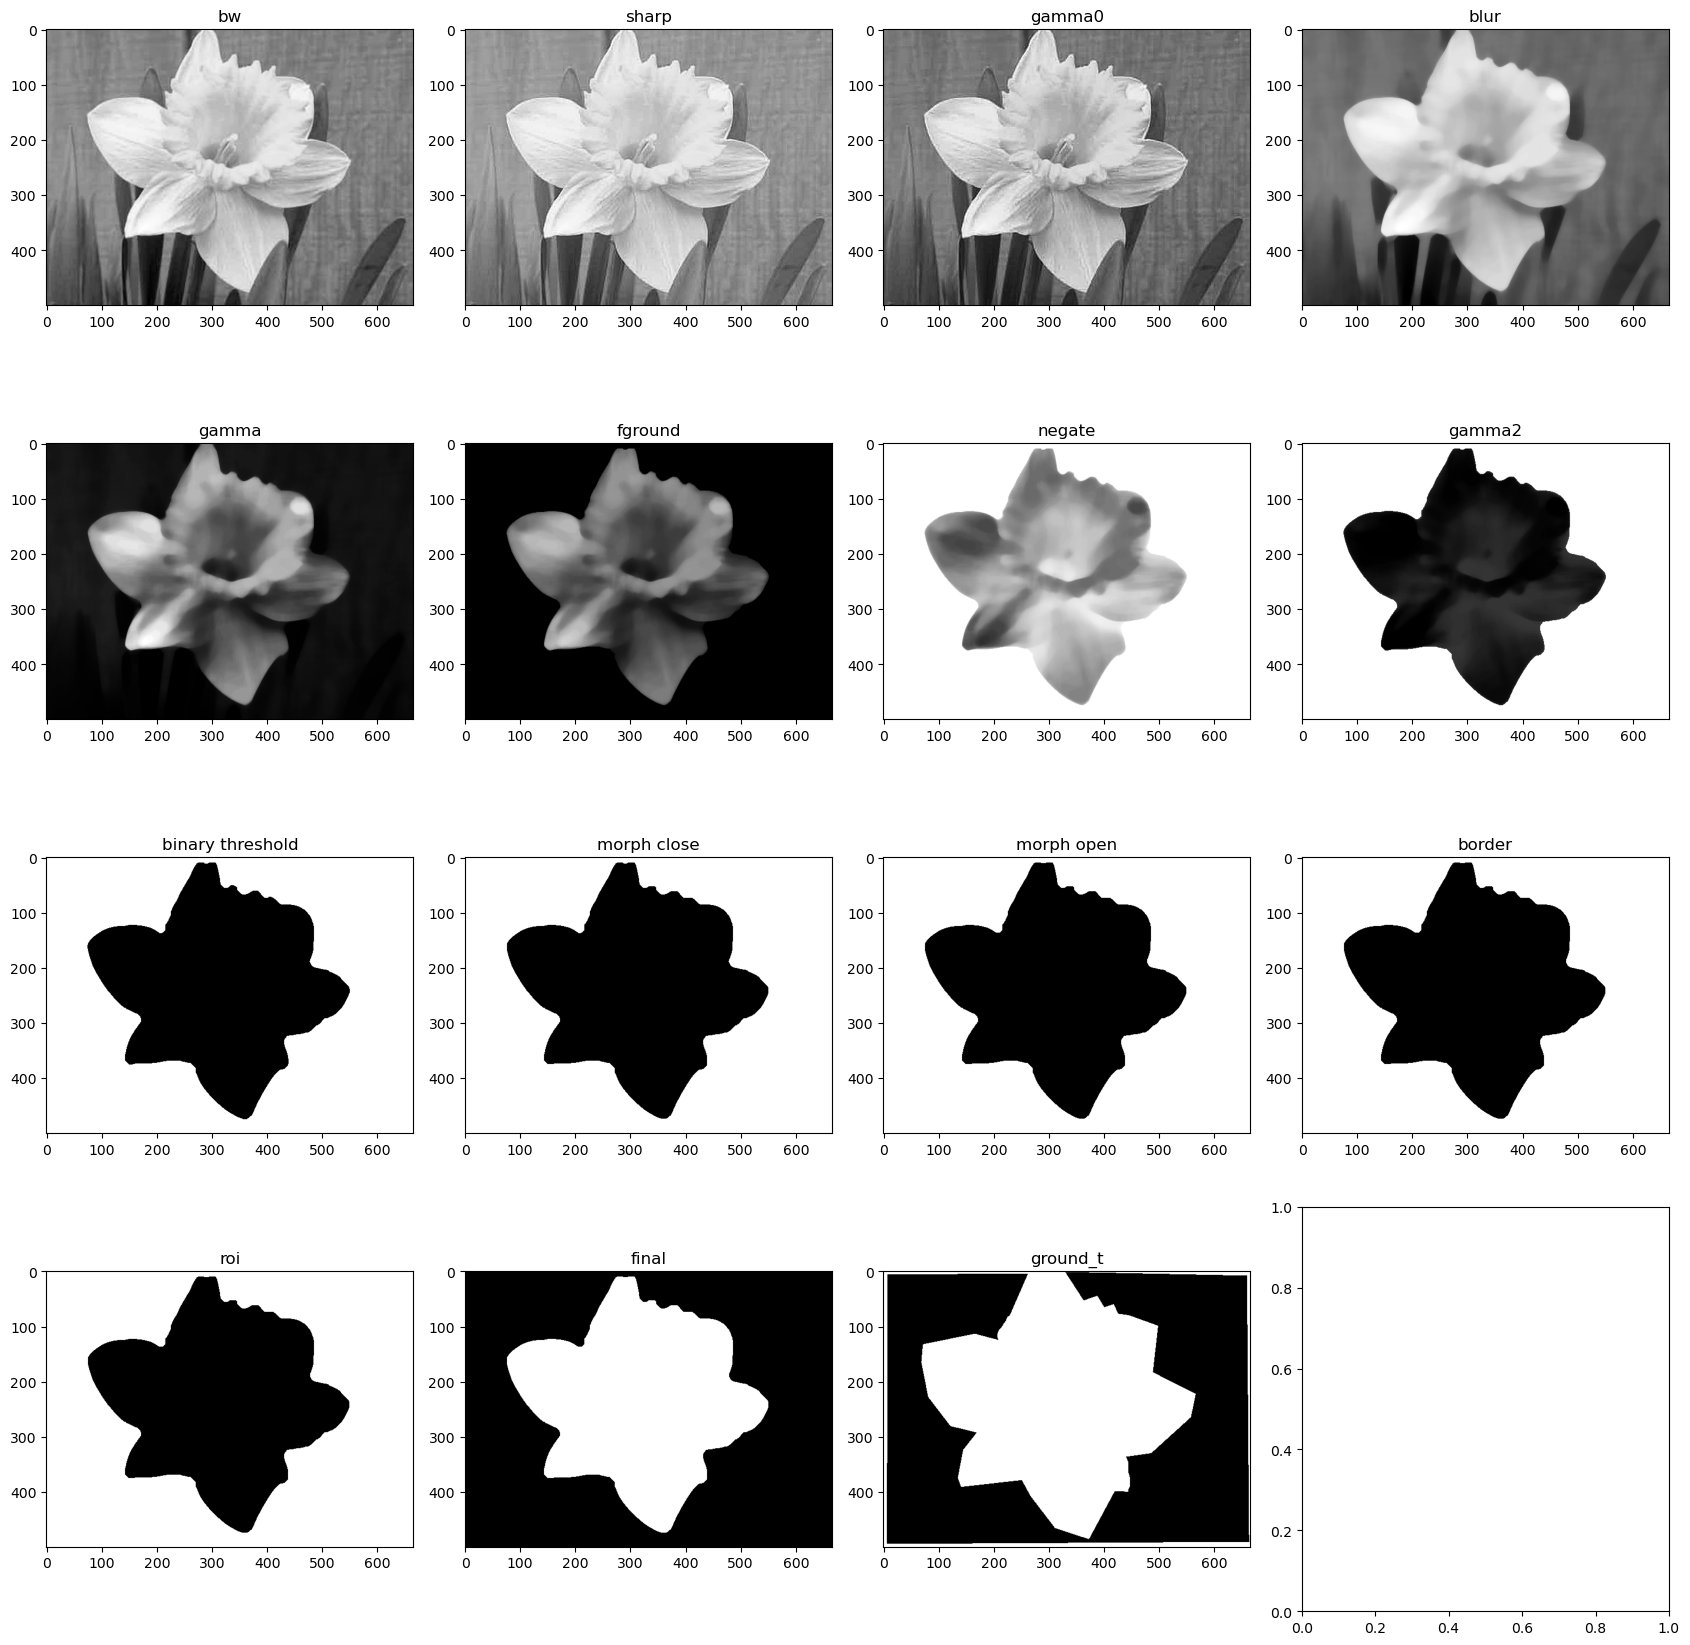

(500, 666)
(500, 666)
similarity:  0.8130288449281223


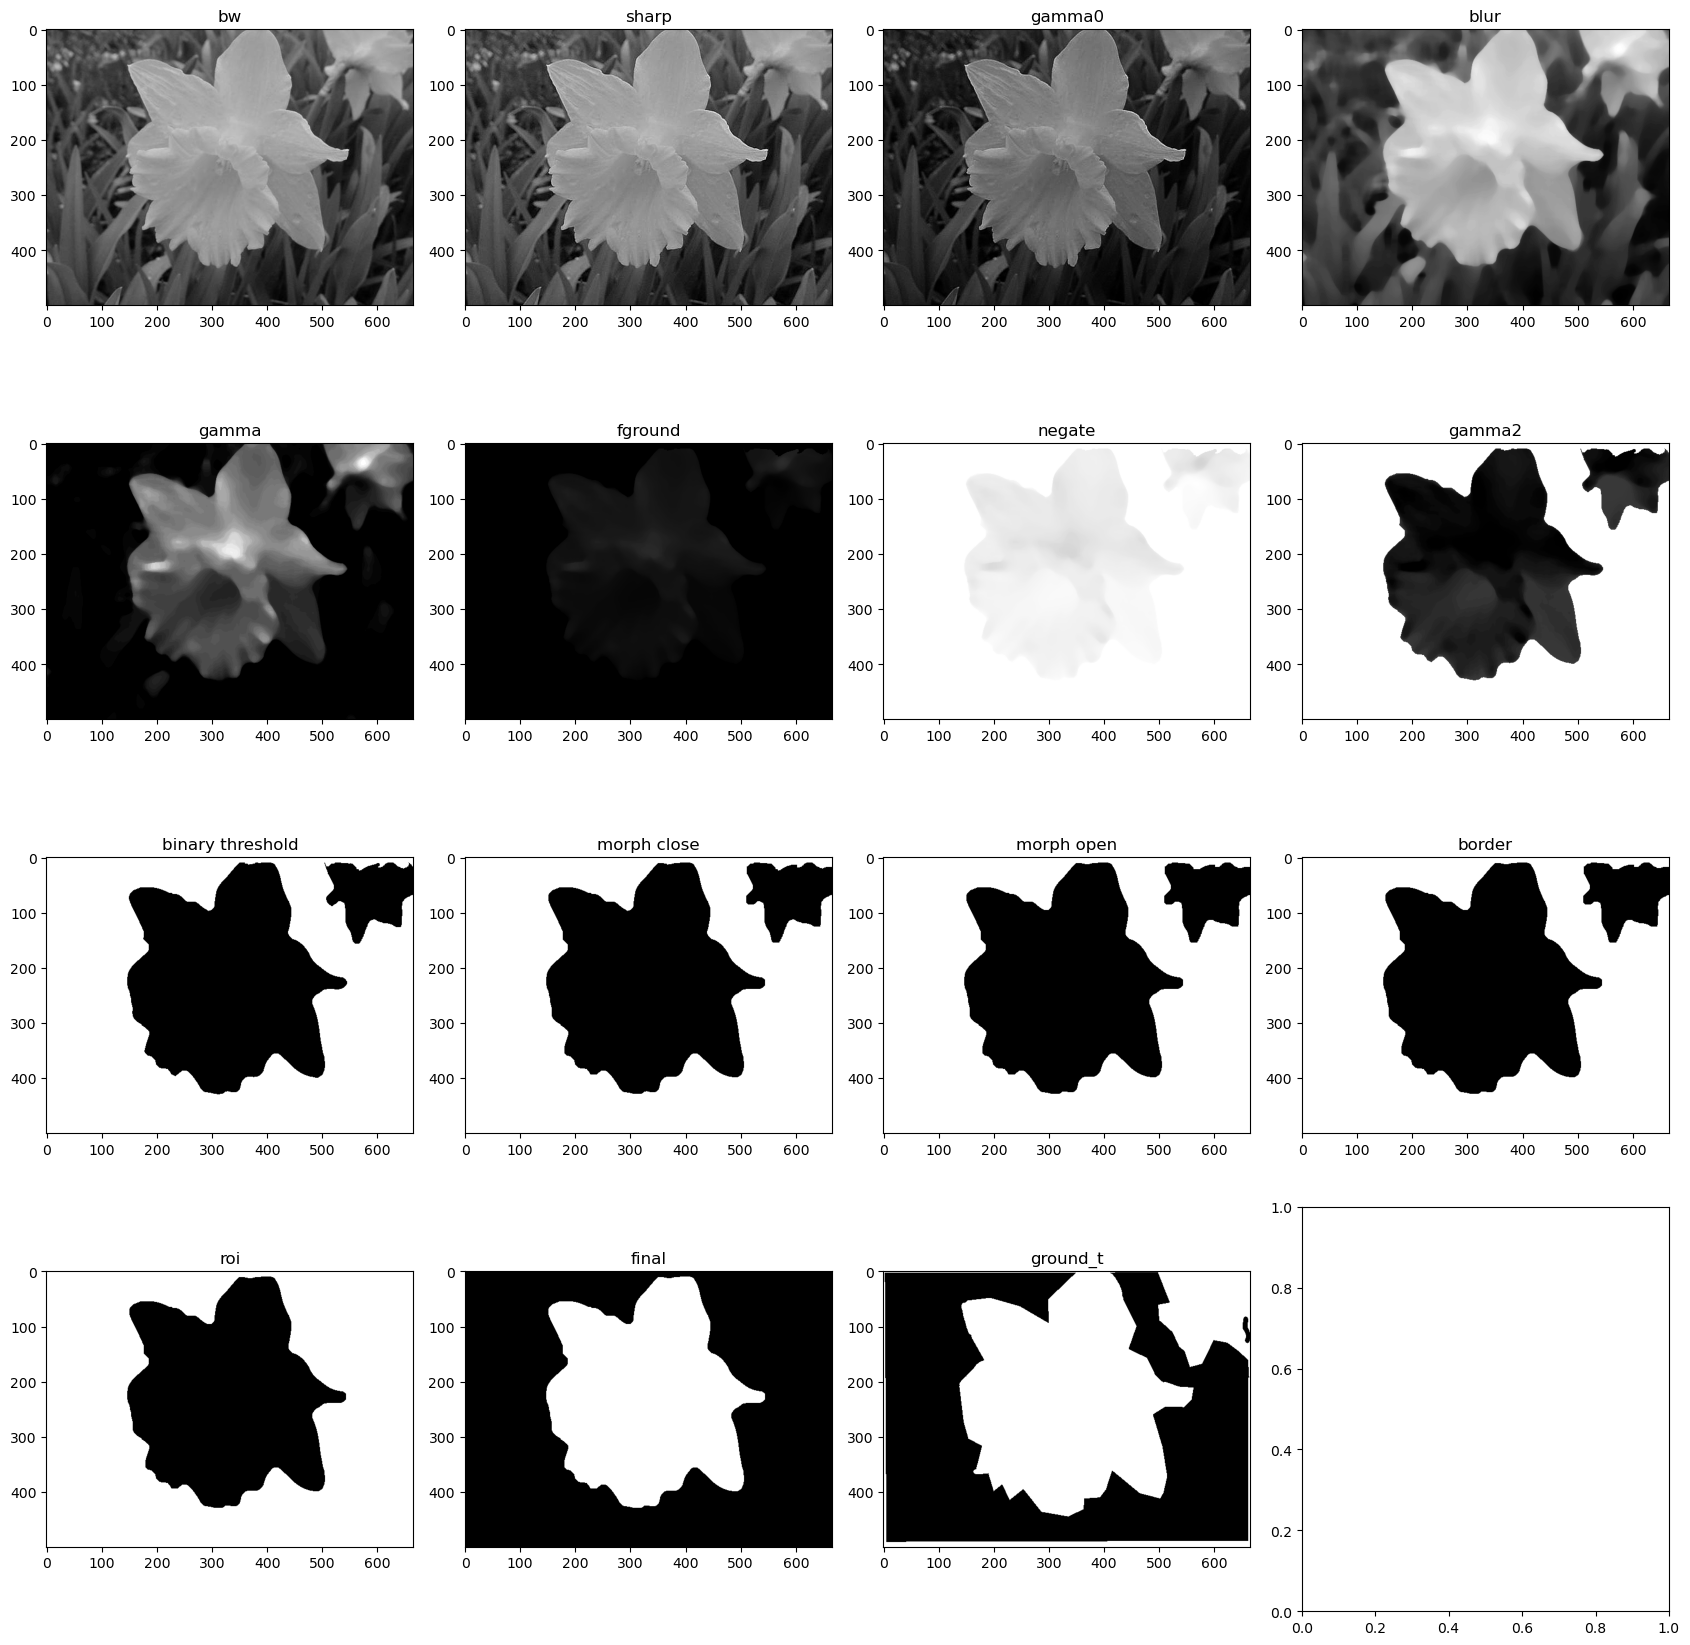

(500, 666)
(500, 666)
similarity:  0.8839141013256694


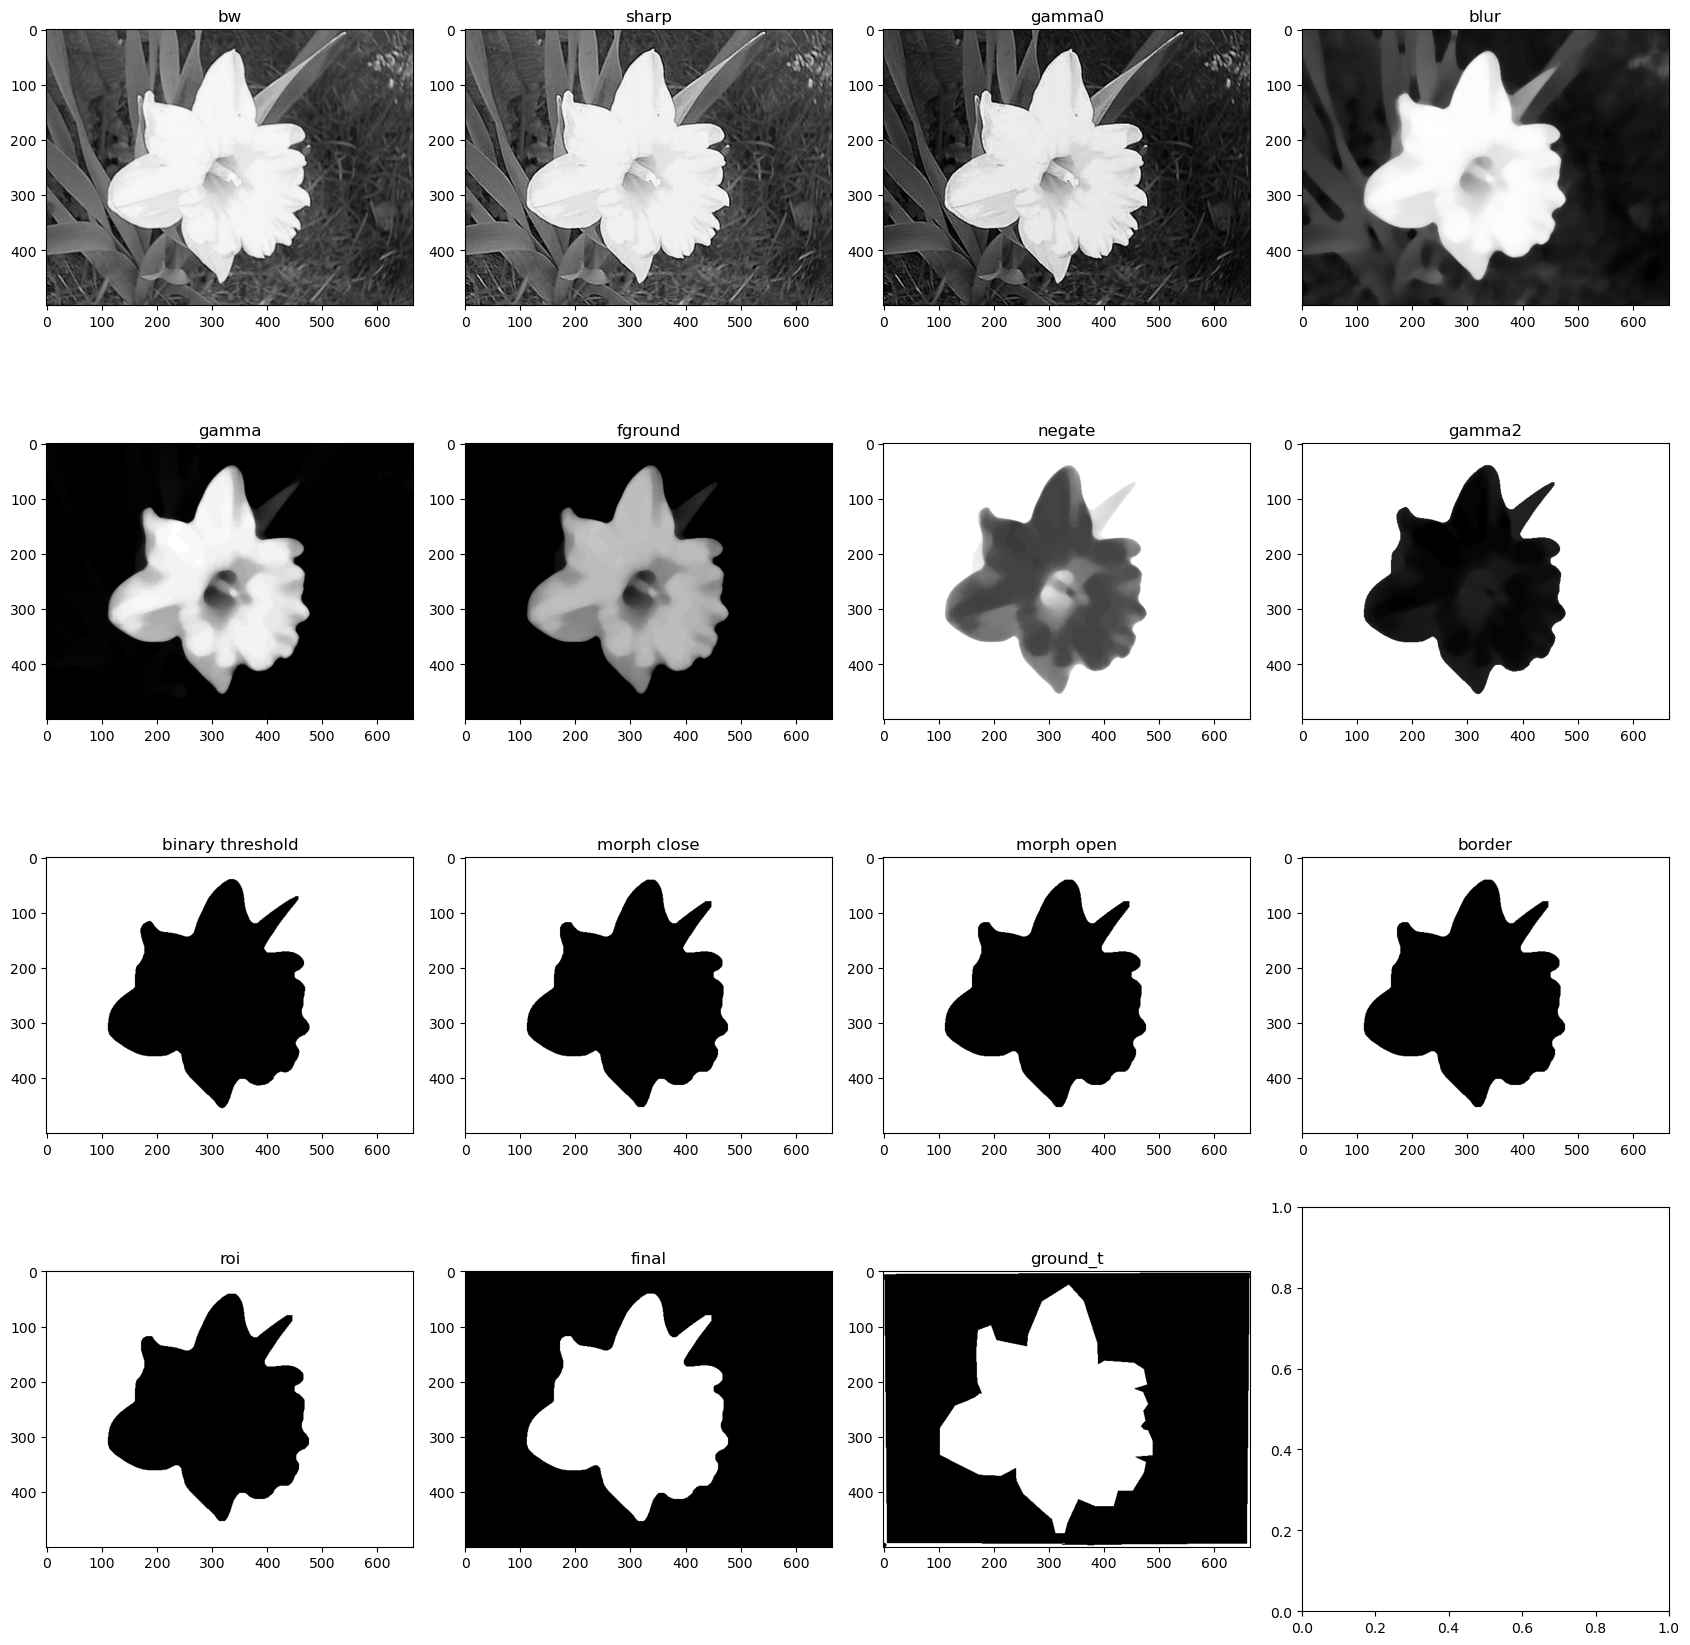

(529, 500)
(529, 500)
similarity:  0.7382382480082906


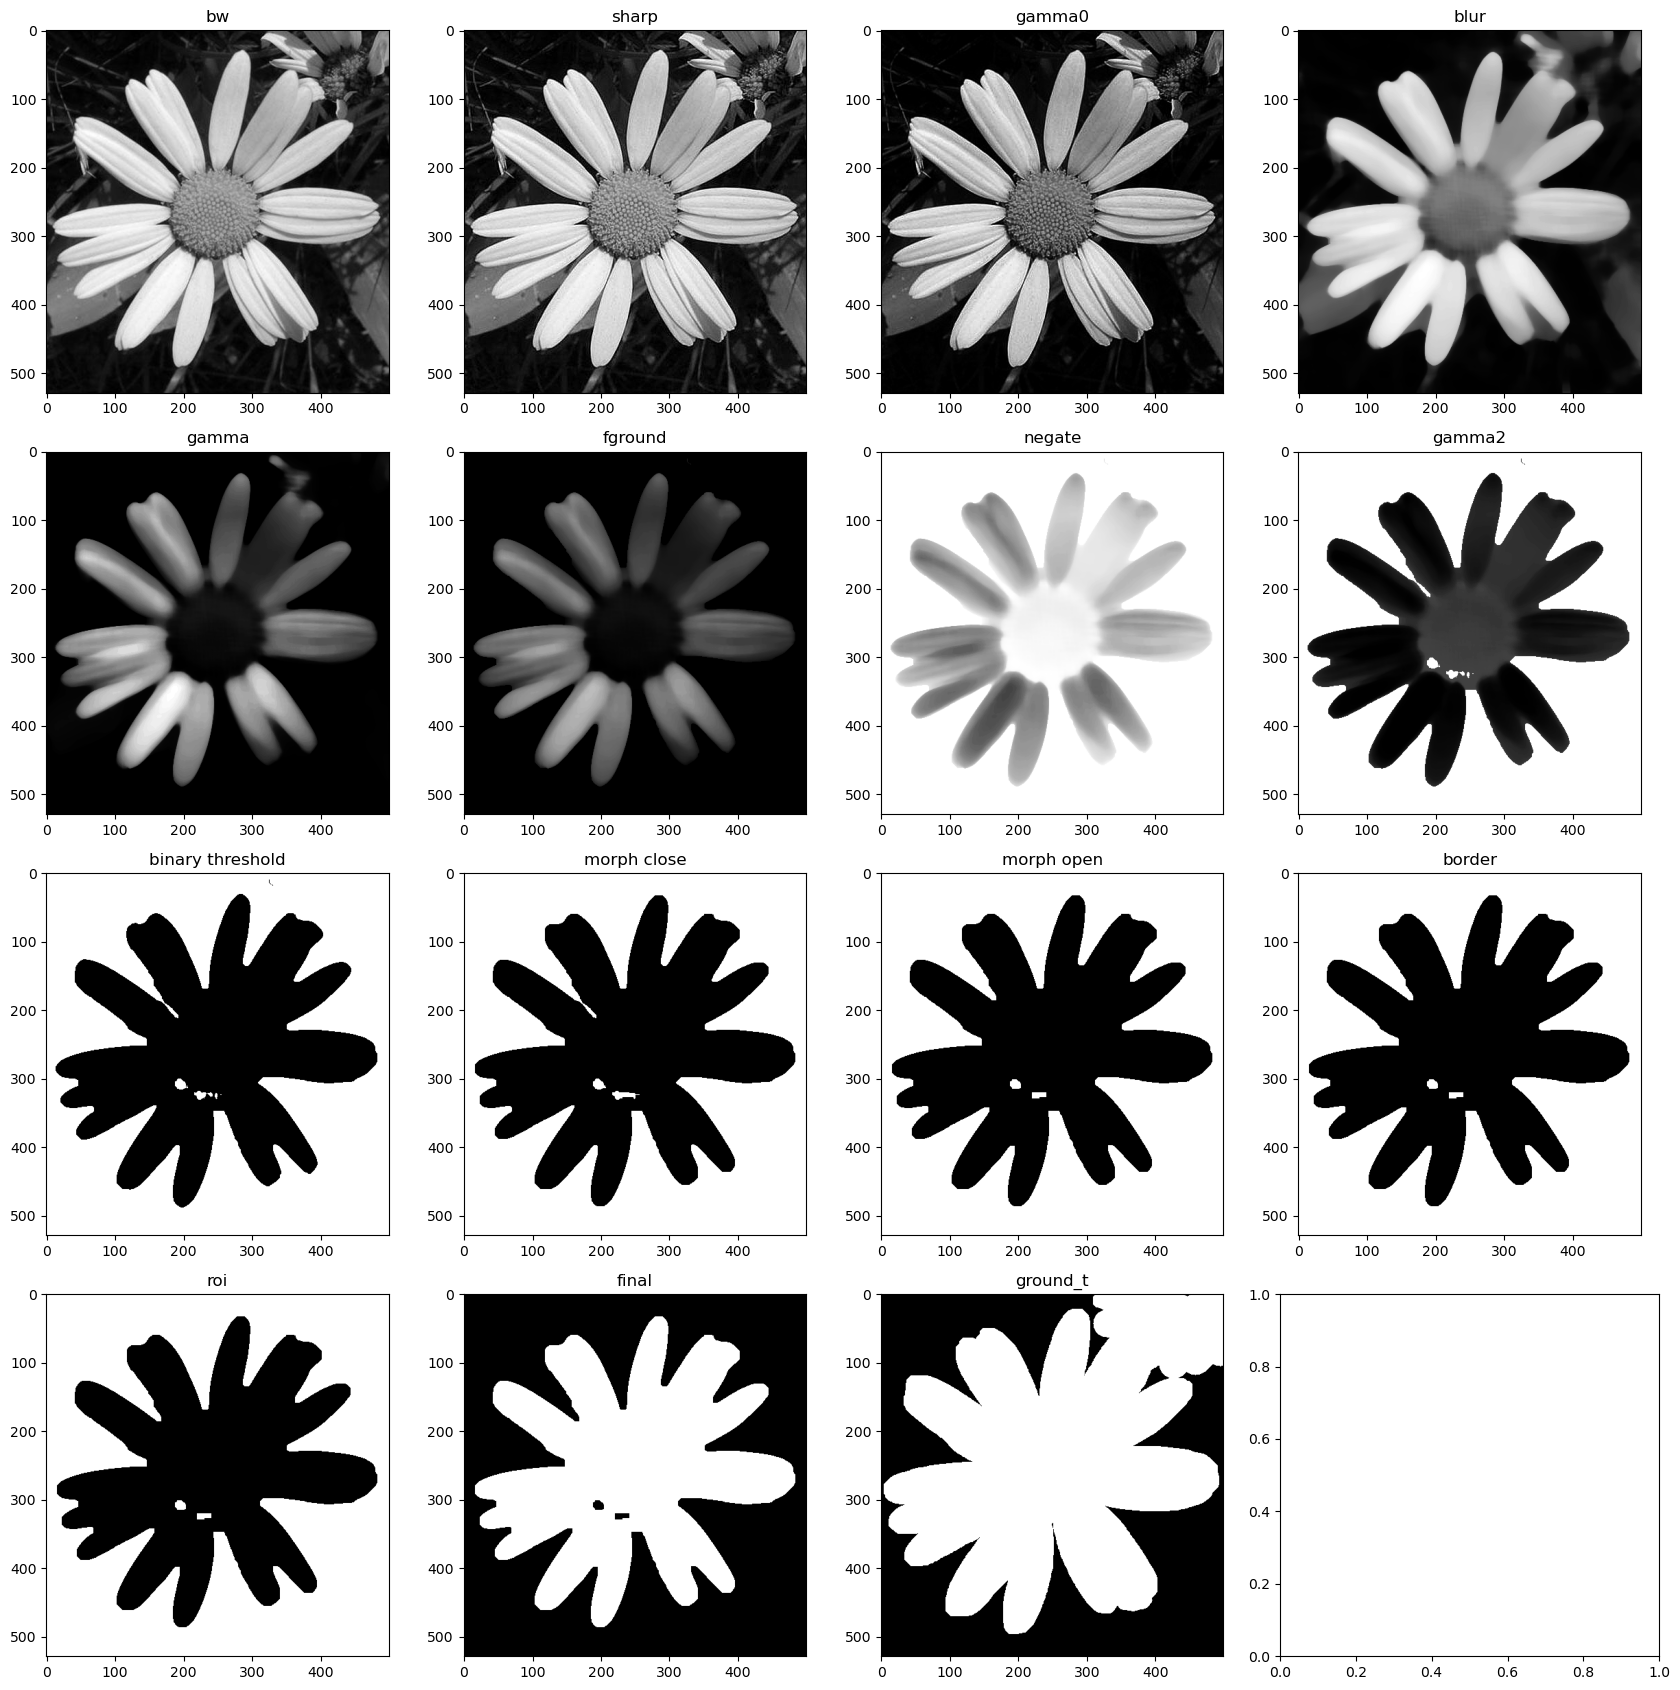

(500, 750)
(500, 750)
similarity:  0.8745817390813173


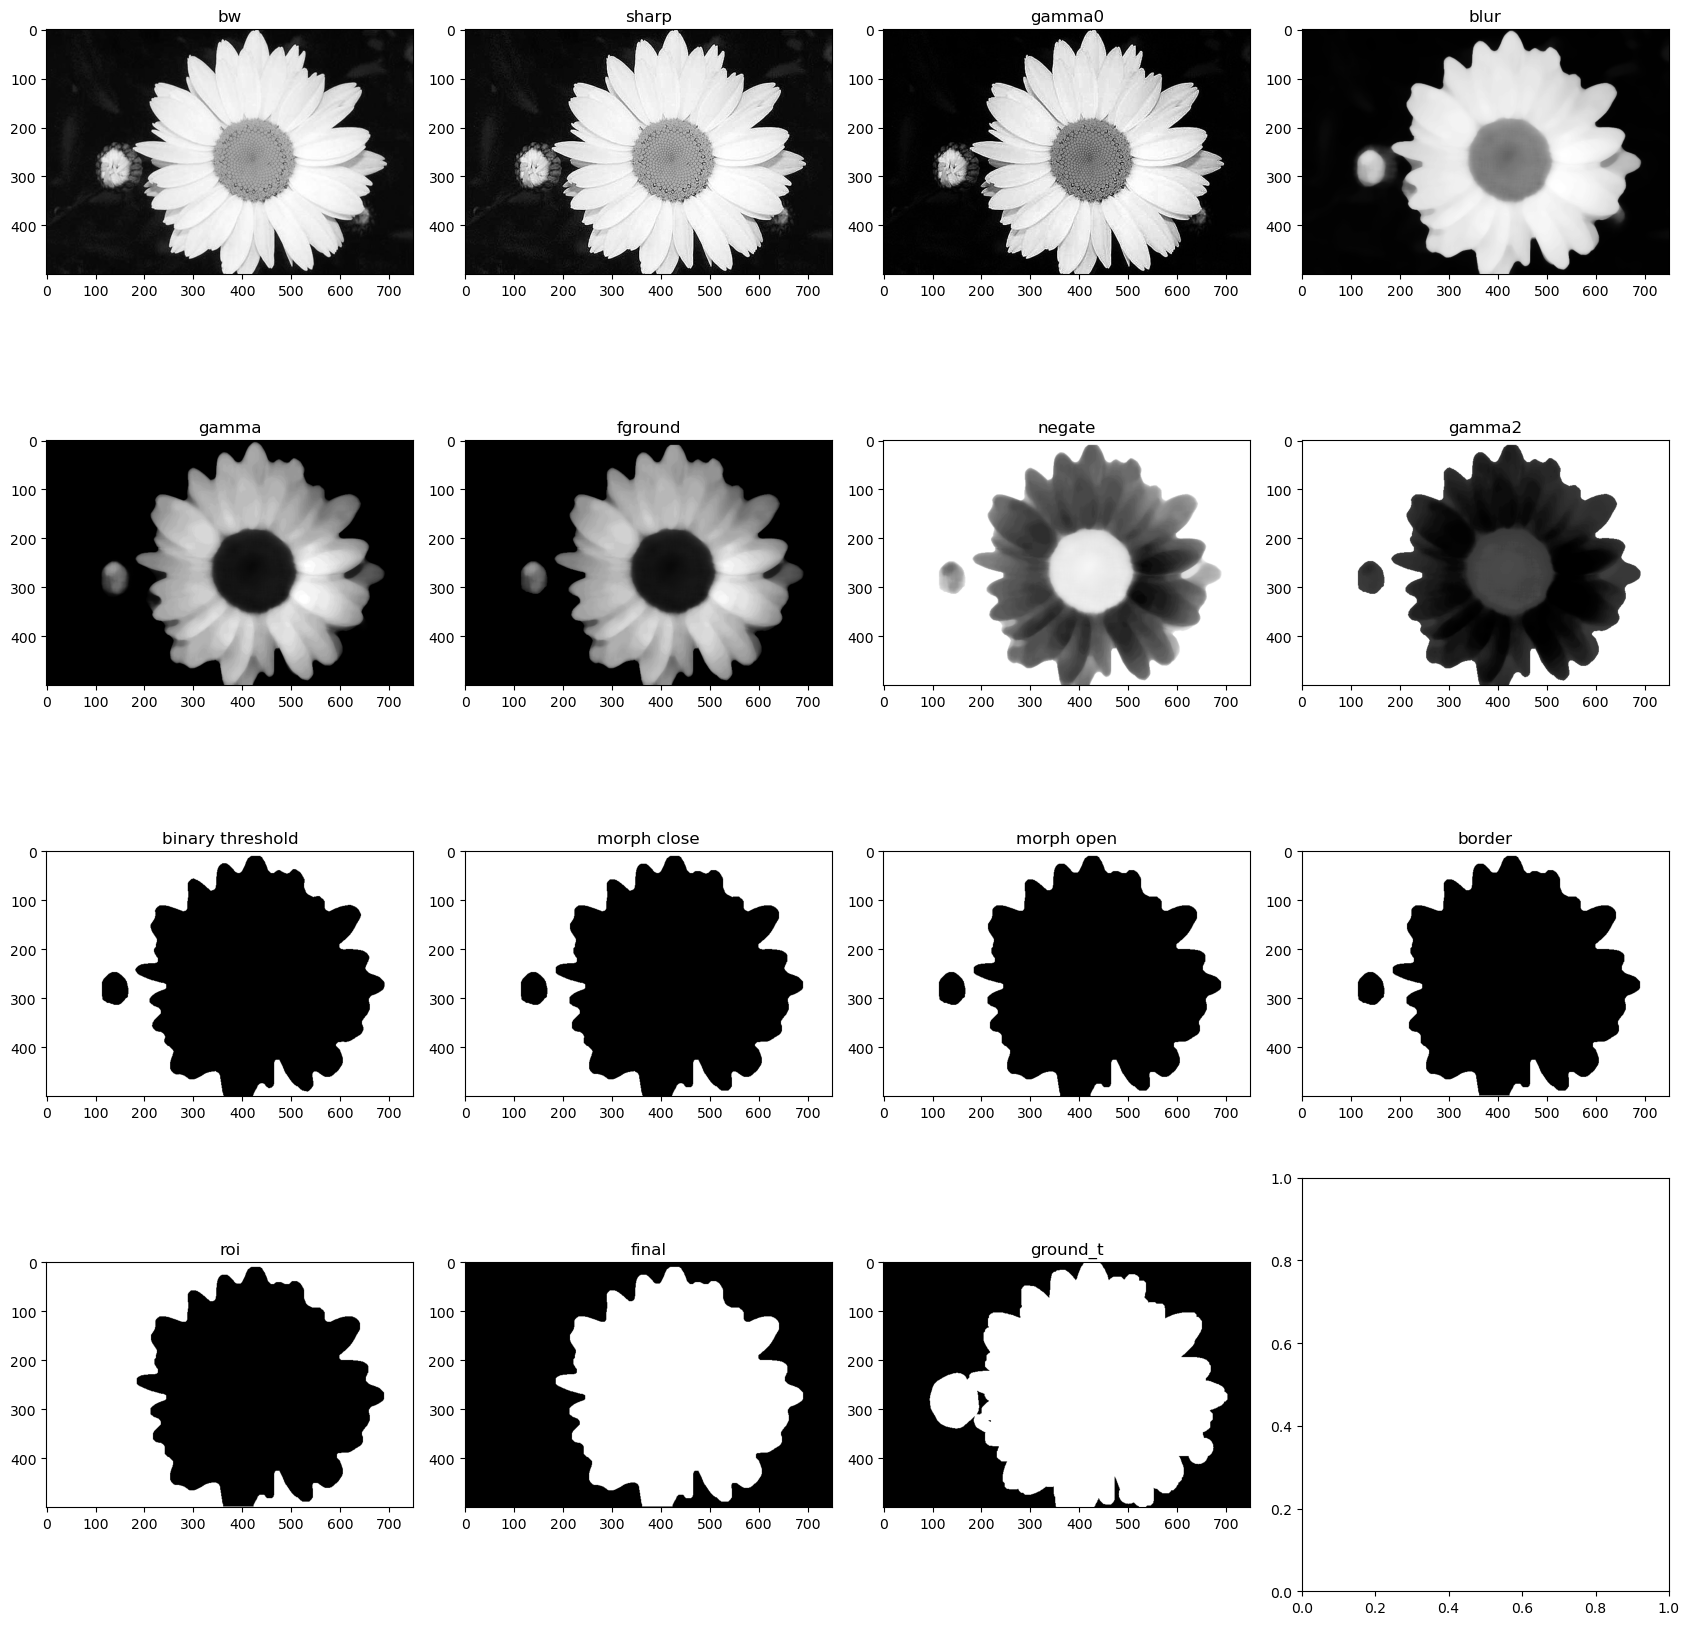

(500, 538)
(500, 538)
similarity:  0.8161950192270413


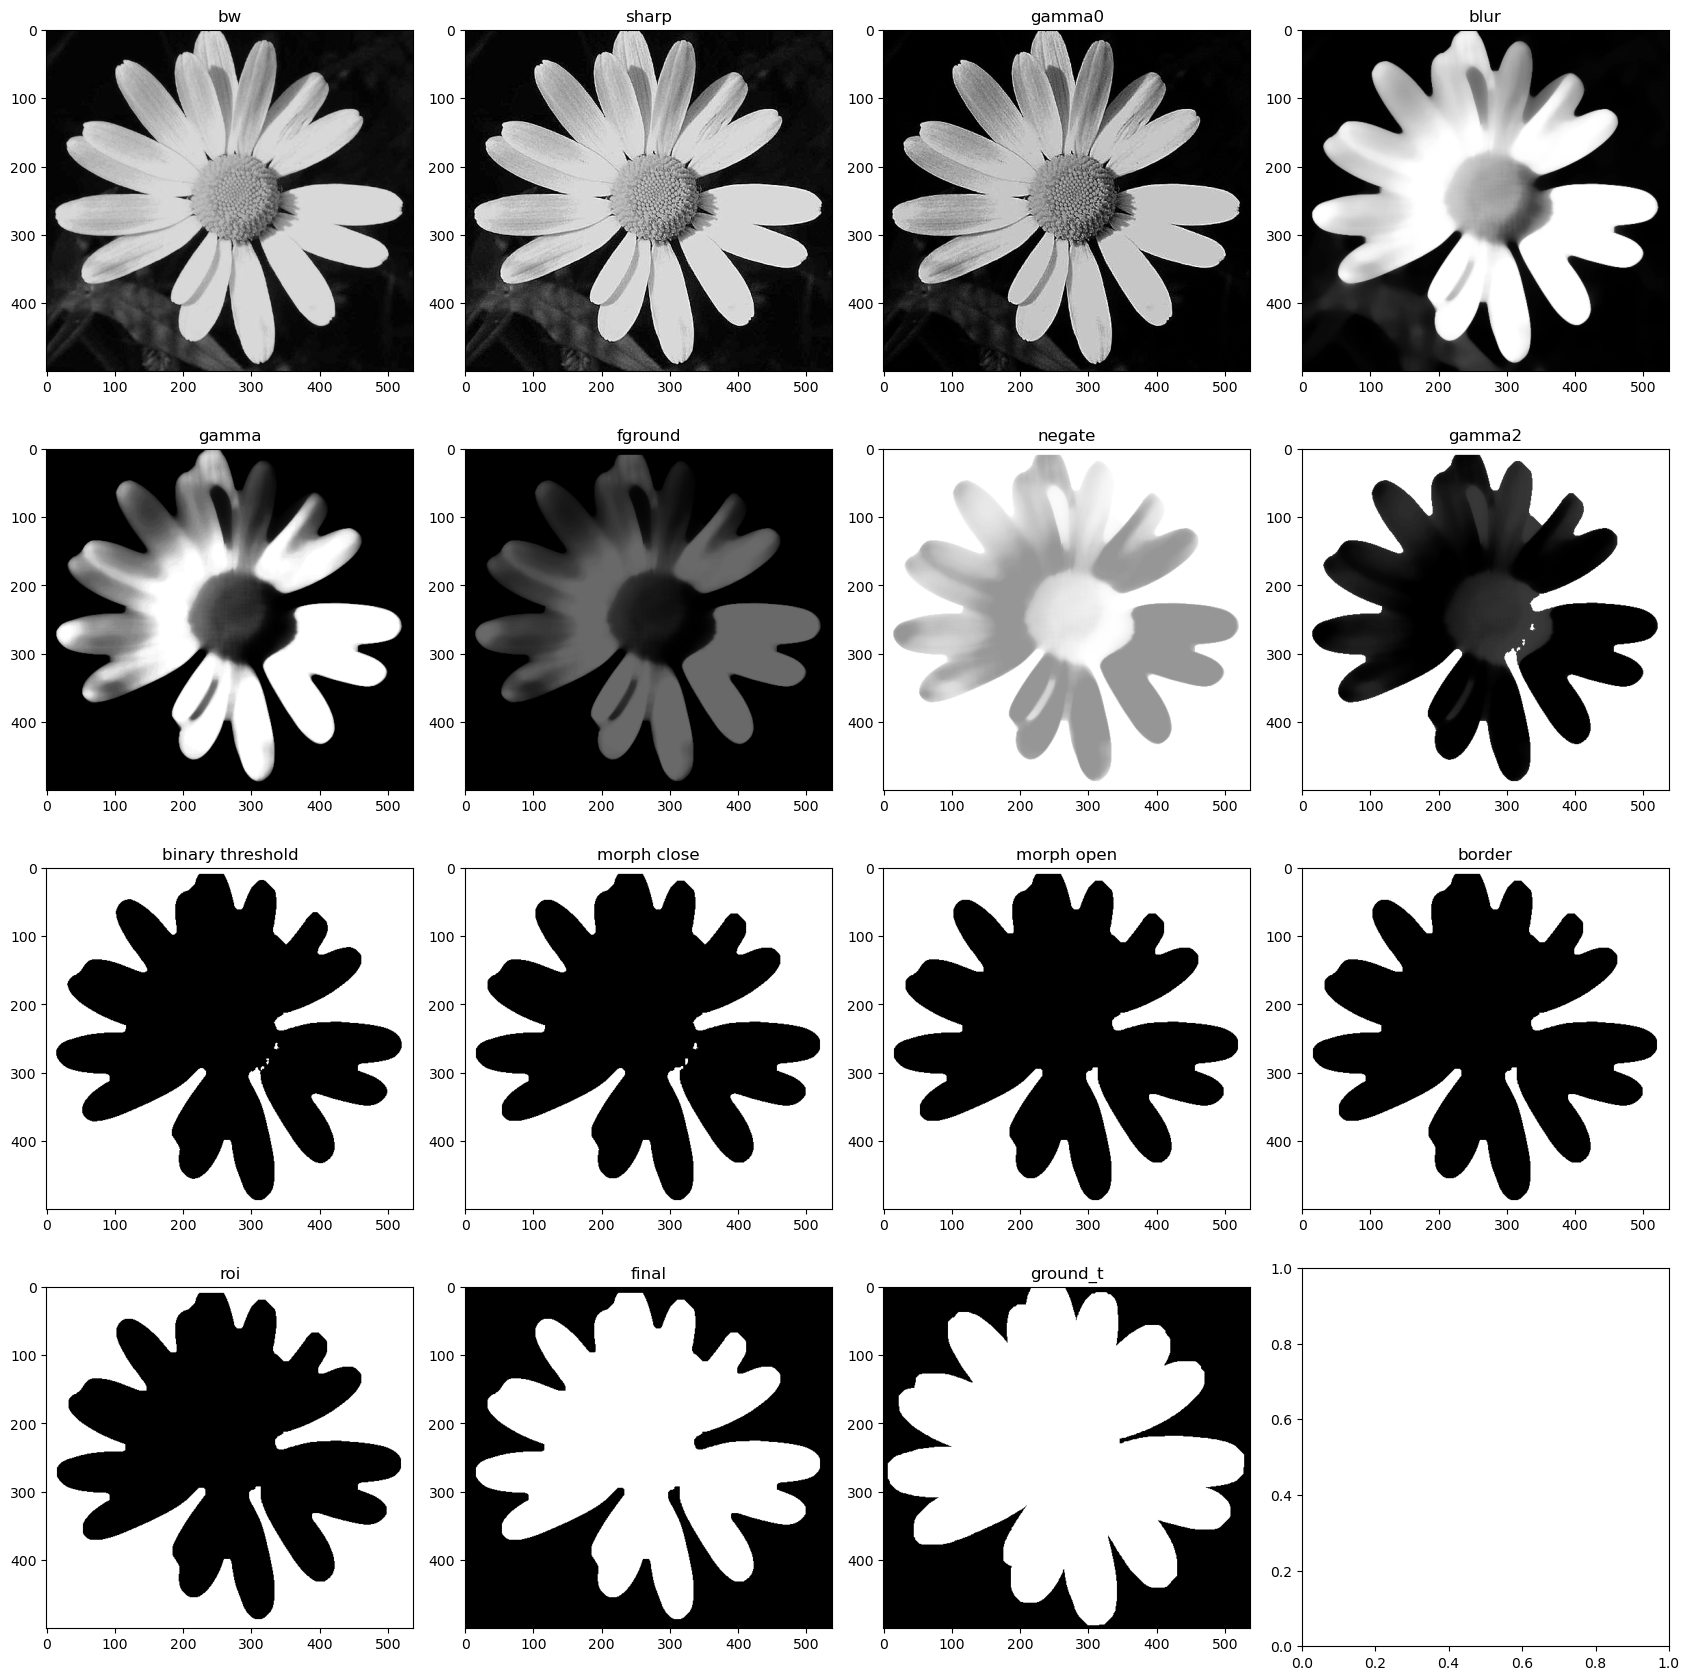

(500, 518)
(500, 518)
similarity:  0.8723836252290824


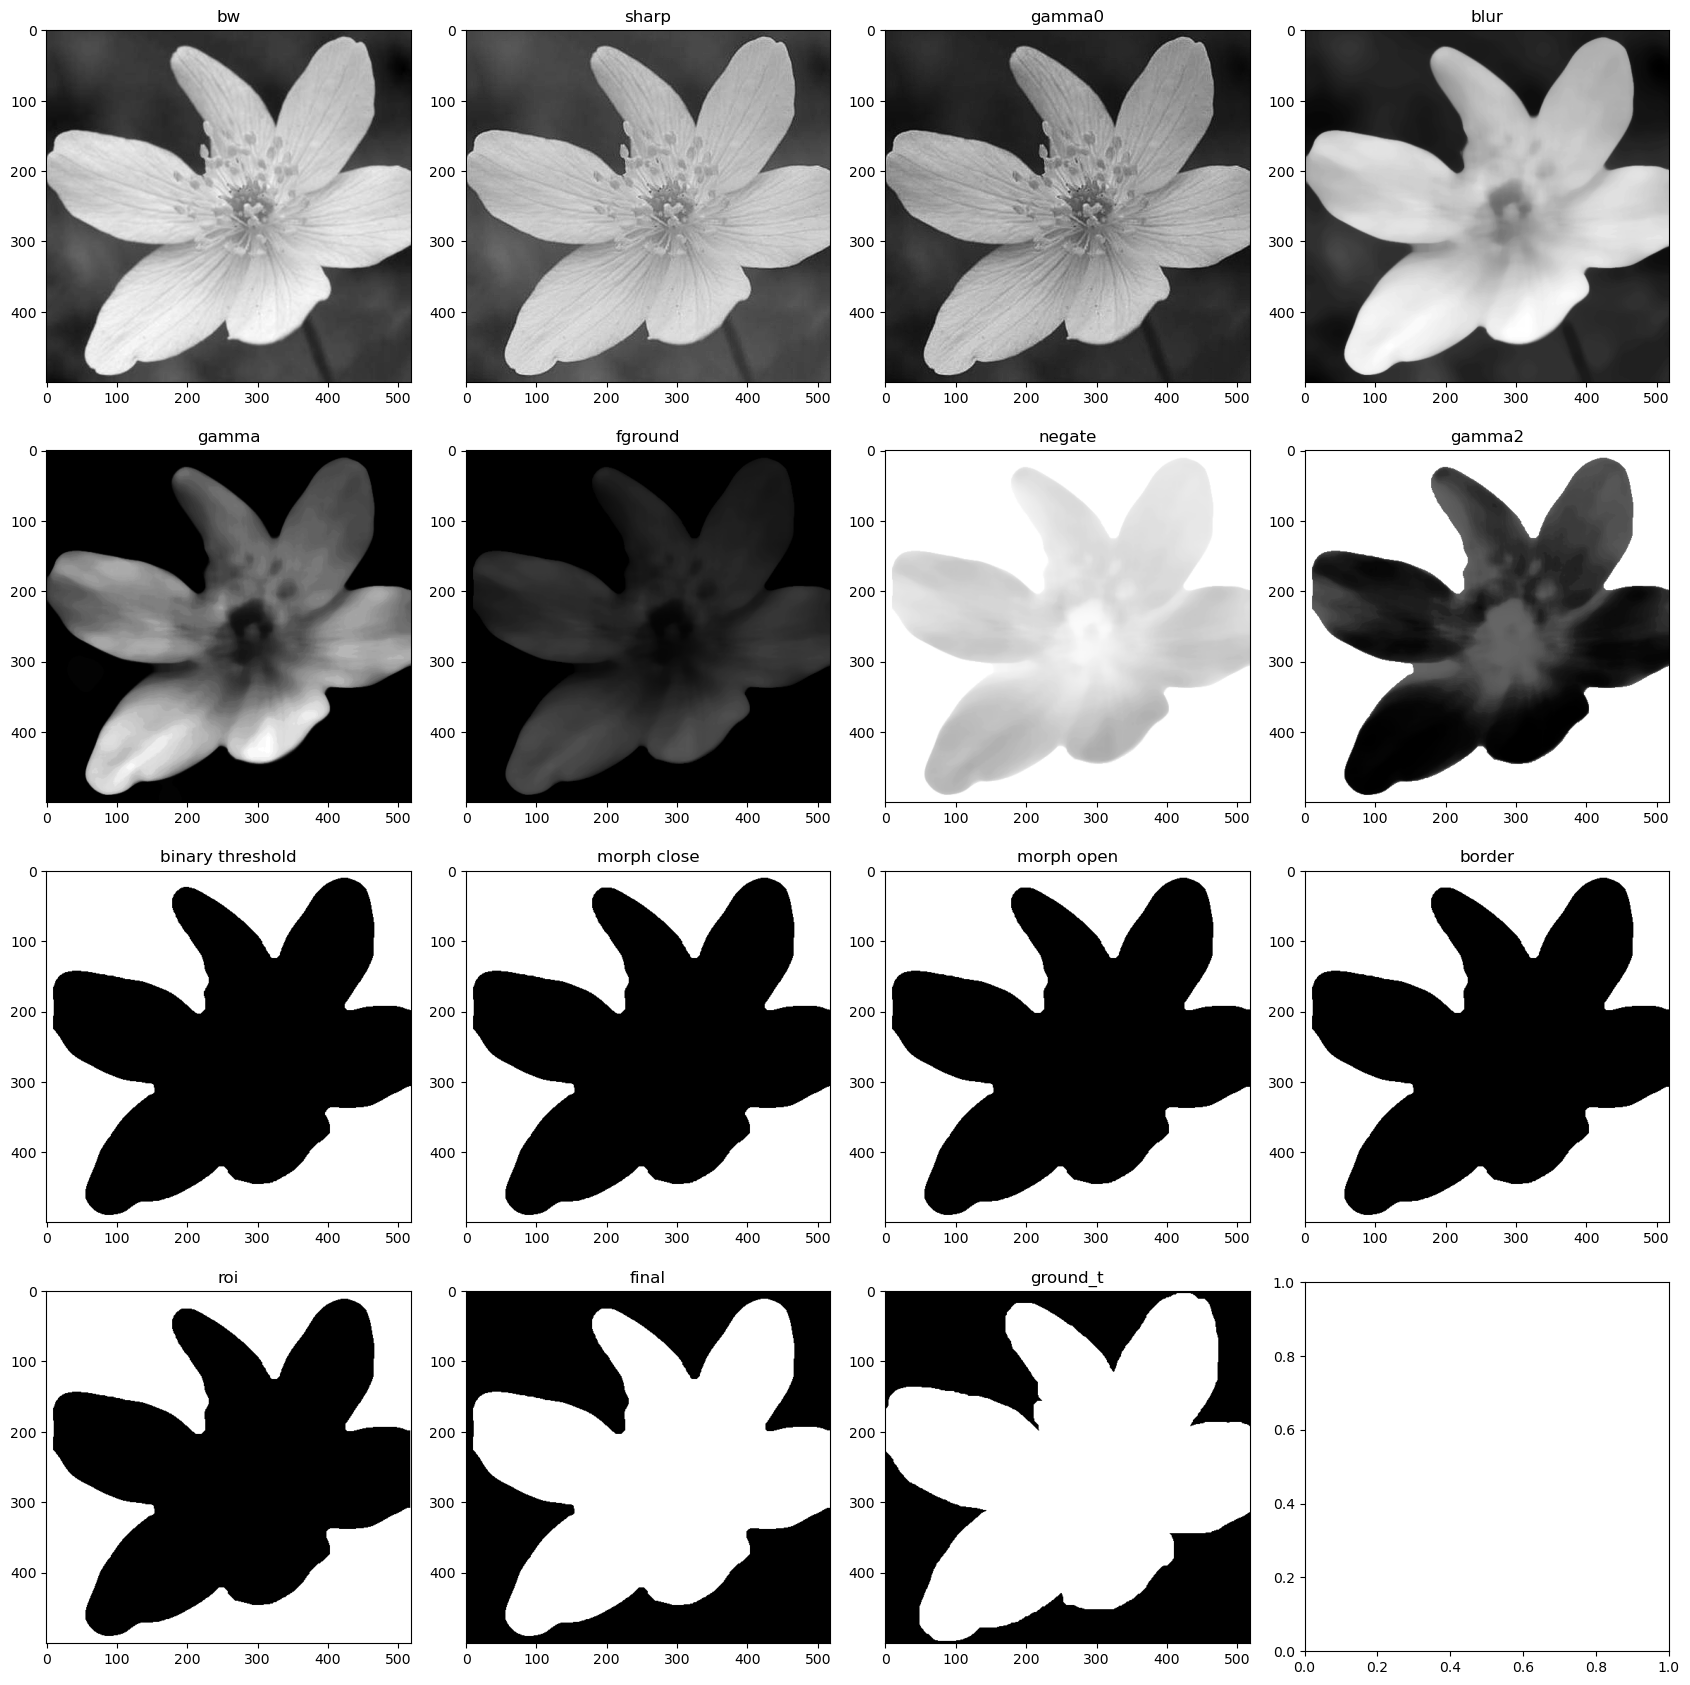

(500, 600)
(500, 600)
similarity:  0.8809357031702663


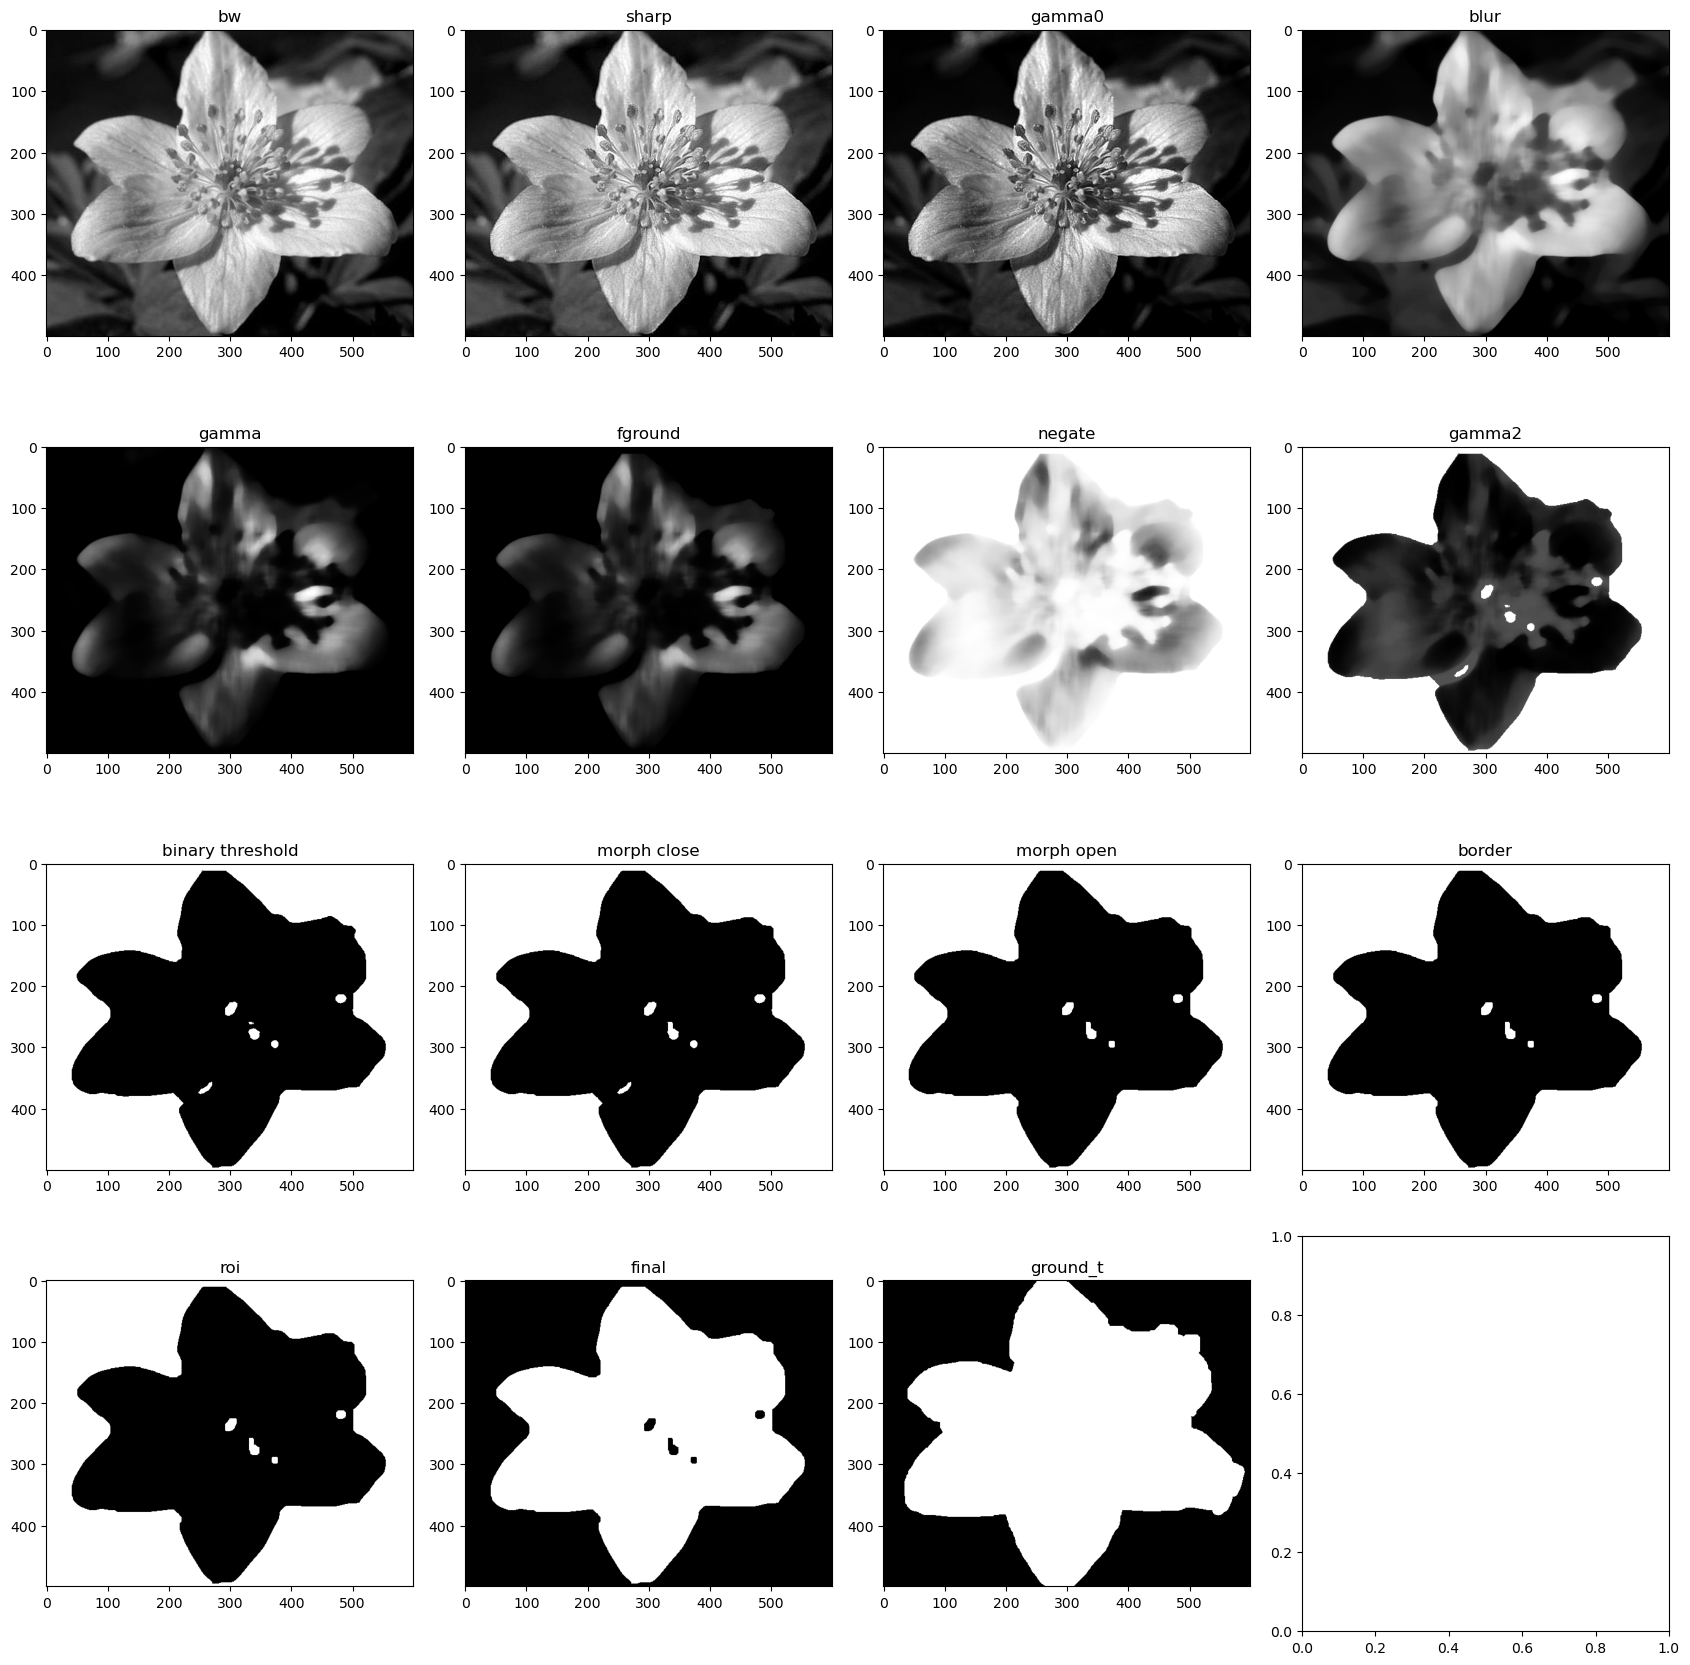

(500, 500)
(500, 500)
similarity:  0.9002574816723781


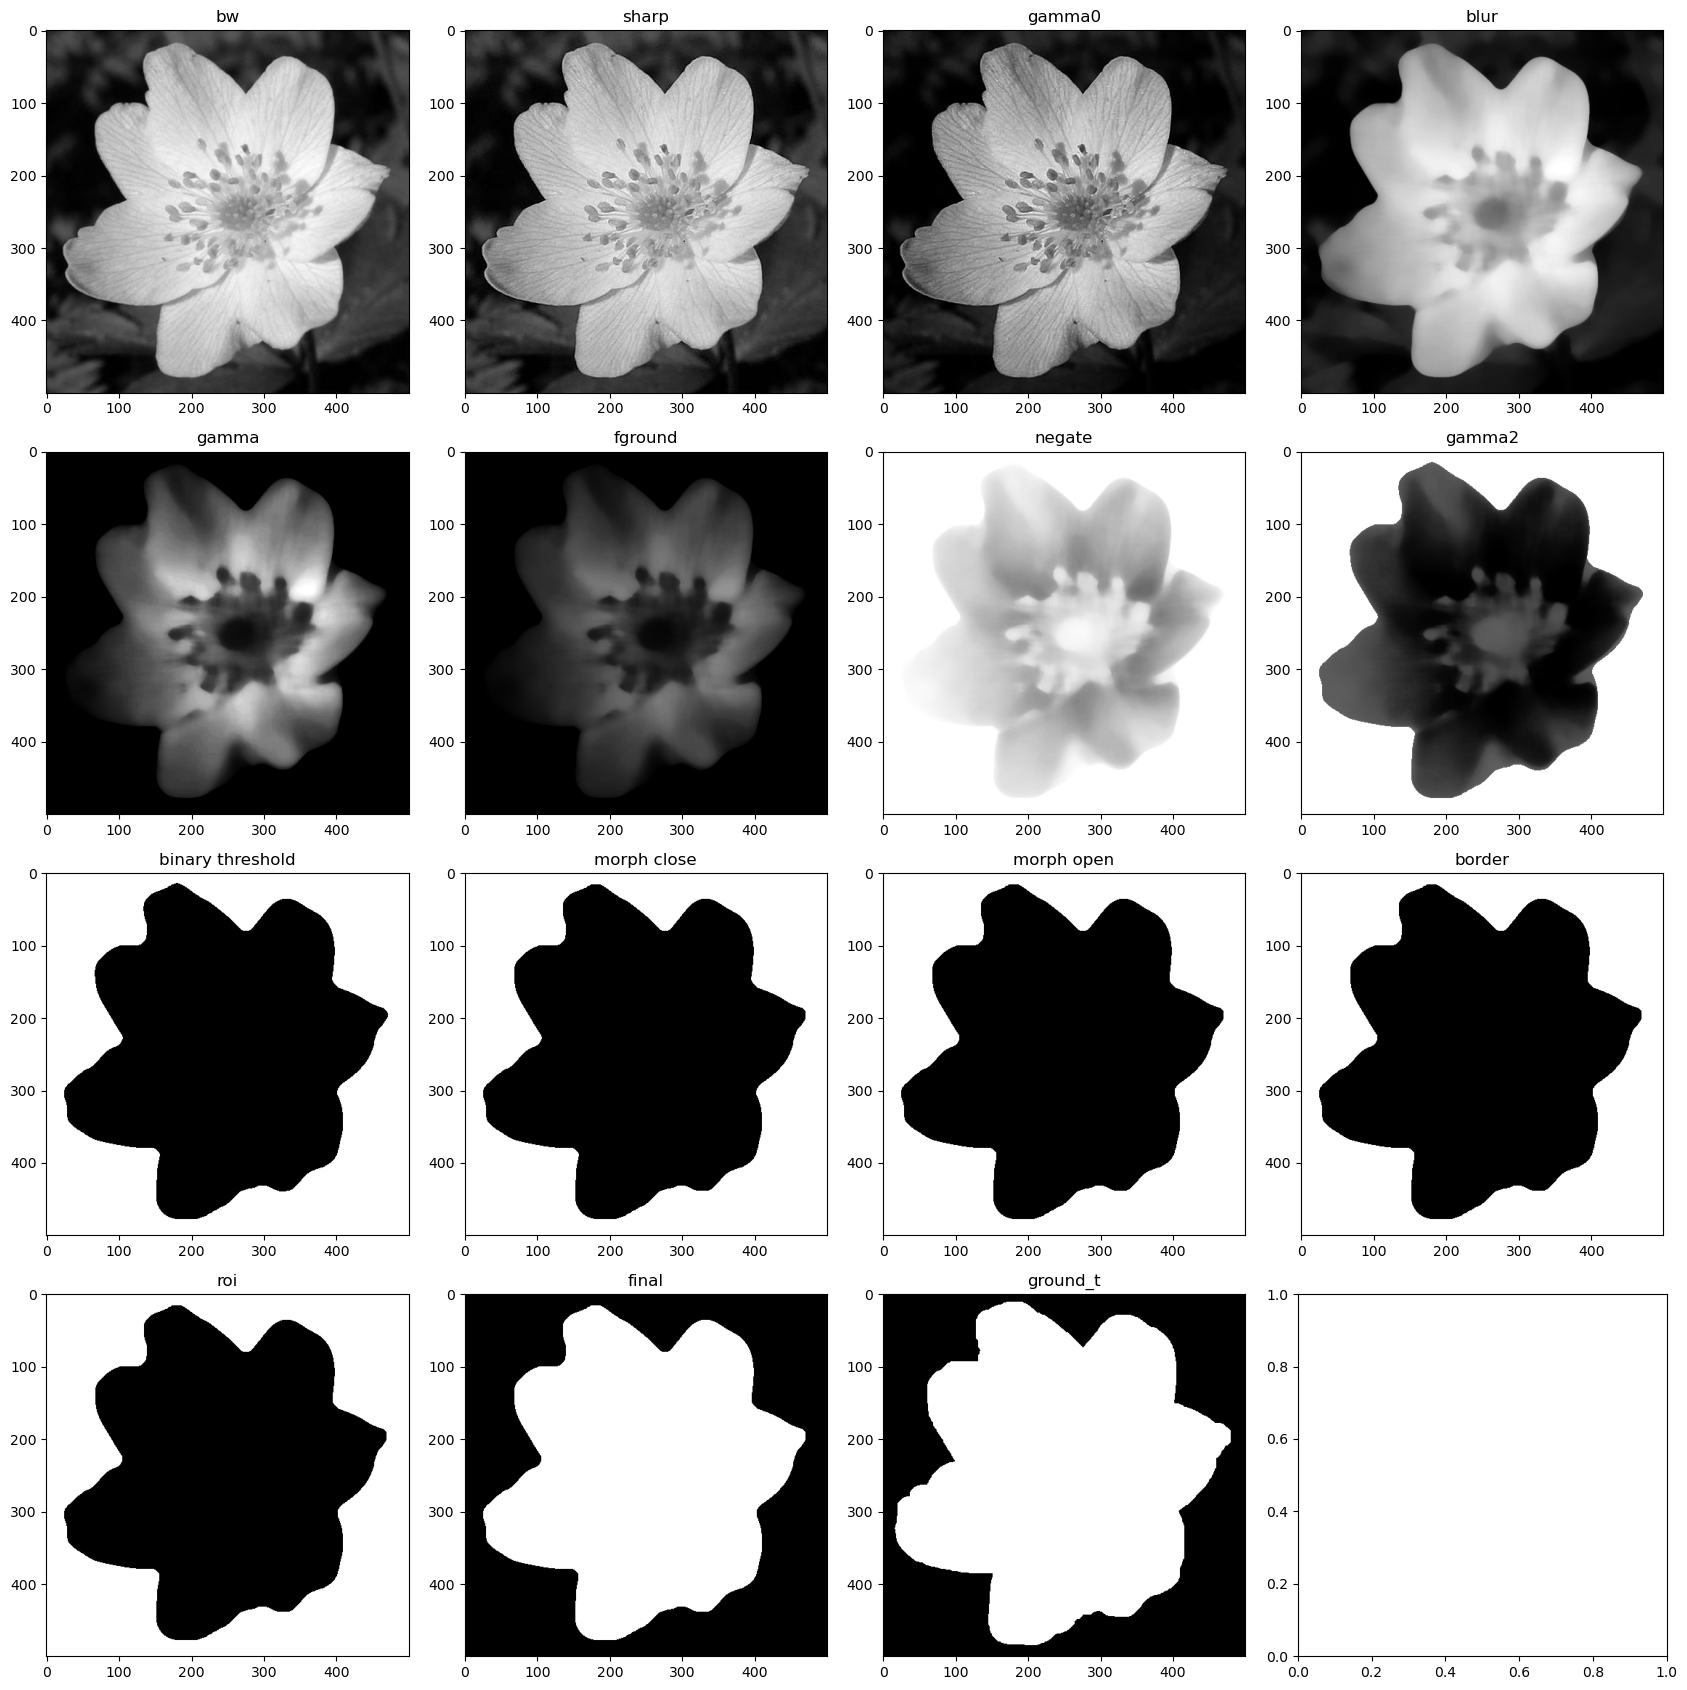

In [27]:
display_pipeline(image_pipeline)